C:\Users\hercu\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step


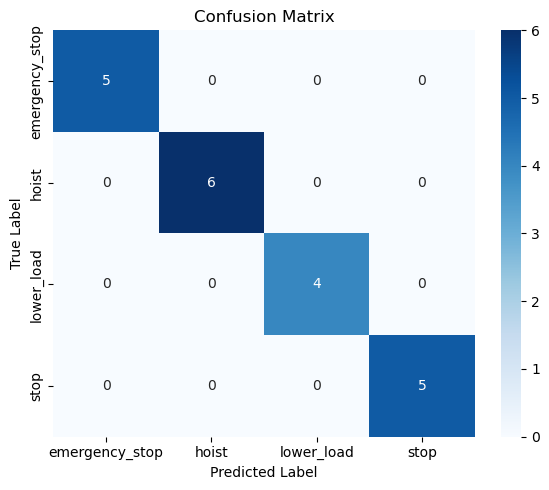

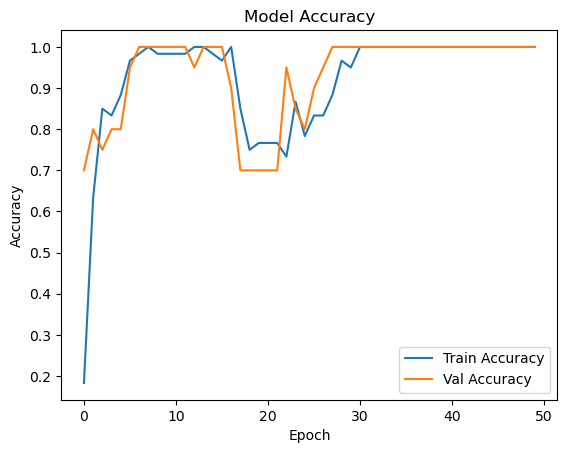

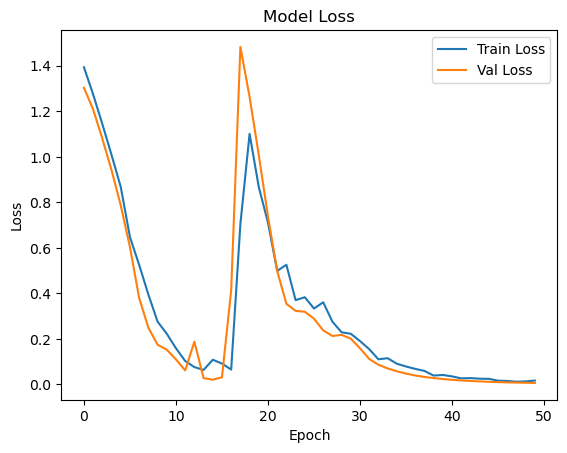

In [9]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# CONFIGURATION
DATA_DIR = "gesture_data"
SEQUENCE_LENGTH = 60
FEATURE_SIZE = 225

# Load gesture samples
X = []
y = []

for label in sorted(os.listdir(DATA_DIR)):
    gesture_folder = os.path.join(DATA_DIR, label)
    if not os.path.isdir(gesture_folder):
        continue
    for file in os.listdir(gesture_folder):
        if file.endswith(".csv"):
            file_path = os.path.join(gesture_folder, file)
            sequence = pd.read_csv(file_path, header=None).values
            if sequence.shape == (SEQUENCE_LENGTH, FEATURE_SIZE):
                X.append(sequence)
                y.append(label)

X = np.array(X)
y = np.array(y)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.25, random_state=42)

# Define LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, FEATURE_SIZE)))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model performance
loss, acc = model.evaluate(X_test, y_test, verbose=0)

# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(pd.DataFrame(cm, index=le.classes_, columns=le.classes_),
            annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Accuracy graph
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss graph
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
